In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolDescriptors as rdmd
from rdkit.Chem.Scaffolds import MurckoScaffold
import pandas as pd
from tqdm import tqdm
import time
import numpy as np
from scipy.spatial.distance import cdist
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,confusion_matrix, roc_auc_score, roc_curve
import seaborn as sns

import numpy as np #
import pandas as pd 
import string
import json
from patsy import dmatrices
from operator import itemgetter
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.metrics import classification_report

In /scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /scratch/ss26

In [2]:
not_to_be_selected_list=[
       'Activity Summary', 'Viability Activity', 'PUBCHEM_ACTIVITY_SCORE',
       'Viability Potency (uM)', 'Viability Efficacy (%)', "index",
                         "Nuclei_Correlation_Manders_AGP_DNA",
            "Nuclei_Correlation_Manders_AGP_ER",
            "Nuclei_Correlation_Manders_AGP_Mito",
            "Nuclei_Correlation_Manders_AGP_RNA",
            "Nuclei_Correlation_Manders_DNA_AGP",
            "Nuclei_Correlation_Manders_DNA_ER",
            "Nuclei_Correlation_Manders_DNA_Mito",
            "Nuclei_Correlation_Manders_DNA_RNA",
            "Nuclei_Correlation_Manders_ER_AGP",
            "Nuclei_Correlation_Manders_ER_DNA",
            "Nuclei_Correlation_Manders_ER_Mito",
            "Nuclei_Correlation_Manders_ER_RNA",
            "Nuclei_Correlation_Manders_Mito_AGP",
            "Nuclei_Correlation_Manders_Mito_DNA",
            "Nuclei_Correlation_Manders_Mito_ER",
            "Nuclei_Correlation_Manders_Mito_RNA",
            "Nuclei_Correlation_Manders_RNA_AGP",
            "Nuclei_Correlation_Manders_RNA_DNA",
            "Nuclei_Correlation_Manders_RNA_ER",
            "Nuclei_Correlation_Manders_RNA_Mito",
            "Nuclei_Correlation_RWC_AGP_DNA",
            "Nuclei_Correlation_RWC_AGP_ER",
            "Nuclei_Correlation_RWC_AGP_Mito",
            "Nuclei_Correlation_RWC_AGP_RNA",
            "Nuclei_Correlation_RWC_DNA_AGP",
            "Nuclei_Correlation_RWC_DNA_ER",
            "Nuclei_Correlation_RWC_DNA_Mito",
            "Nuclei_Correlation_RWC_DNA_RNA",
            "Nuclei_Correlation_RWC_ER_AGP",
            "Nuclei_Correlation_RWC_ER_DNA",
            "Nuclei_Correlation_RWC_ER_Mito",
            "Nuclei_Correlation_RWC_ER_RNA",
            "Nuclei_Correlation_RWC_Mito_AGP",
            "Nuclei_Correlation_RWC_Mito_DNA",
            "Nuclei_Correlation_RWC_Mito_ER",
            "Nuclei_Correlation_RWC_Mito_RNA",
            "Nuclei_Correlation_RWC_RNA_AGP",
            "Nuclei_Correlation_RWC_RNA_DNA",
            "Nuclei_Correlation_RWC_RNA_ER",
            "Nuclei_Correlation_RWC_RNA_Mito",
            "Nuclei_Granularity_14_AGP",
            "Nuclei_Granularity_14_DNA",
            "Nuclei_Granularity_14_ER",
            "Nuclei_Granularity_14_Mito",
            "Nuclei_Granularity_14_RNA",
            "Nuclei_Granularity_15_AGP",
            "Nuclei_Granularity_15_DNA",
            "Nuclei_Granularity_15_ER",
            "Nuclei_Granularity_15_Mito",
            "Nuclei_Granularity_15_RNA",
            "Nuclei_Granularity_16_AGP",
            "Nuclei_Granularity_16_DNA",
            "Nuclei_Granularity_16_ER",
            "Nuclei_Granularity_16_Mito",
            "Nuclei_Granularity_16_RNA"]

In [3]:
info= [    
    
    "StdInChI",
    "PUBCHEM_ACTIVITY_OUTCOME"]


In [5]:
df =pd.read_csv("GO_CP_MitoOverlap_nocelldeath.csv" ,  usecols=lambda x: x not in not_to_be_selected_list)
df =df[df.PUBCHEM_ACTIVITY_OUTCOME != "Inconclusive"]
#df = df.replace({'PUBCHEM_ACTIVITY_OUTCOME': {"Active": 1, "Inactive": 0}})
df

/scratch/ss2686/envs/my-rdkit-env/lib/python3.6/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


,StdInChI,PUBCHEM_ACTIVITY_OUTCOME,Metadata_mmoles_per_liter,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,...,transcription corepressor activity (GO:0003714),mRNA processing (GO:0006397),regulation of cell proliferation involved in heart morphogenesis (GO:2000136),transport vesicle membrane (GO:0030658),intra-S DNA damage checkpoint (GO:0031573),negative regulation of smooth muscle contraction (GO:0045986),response to molecule of bacterial origin (GO:0002237),HOPS complex (GO:0030897),positive regulation of megakaryocyte differentiation (GO:0045654),negative regulation of sister chromatid segregation (GO:0033046)
0,InChI=1S/C10H10N2O/c1-8-7-10(13)12(11-8)9-5-3-...,1,14.351386,83.085938,6.679688,-2.980469,-0.003898,0.002892,0.0,-0.001432,...,0.5539,-0.0000,4.3861,2.3619,-0.0000,2.1116,11.9425,-0.0000,0.6807,-0.0000
1,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",0,5.000000,-322.046875,2.464844,0.167969,-0.015848,-0.005454,0.0,-0.000505,...,0.2687,-0.0000,0.7811,0.5063,0.0138,0.0383,7.0154,-0.0000,0.6232,0.2421
2,"InChI=1S/C10H11ClO3/c1-10(2,9(12)13)14-8-5-3-7...",0,5.000000,248.234375,-0.906250,2.101562,0.020288,0.015127,0.0,-0.003586,...,3.4310,0.0210,3.8991,0.0773,0.0577,0.9919,11.8015,0.8738,0.1300,0.1722
3,InChI=1S/C10H11N3O3S/c1-7-6-10(12-16-7)13-17(1...,0,5.000000,52.718750,2.210938,-7.246094,0.012083,0.009969,0.0,0.002822,...,1.3654,-0.0000,0.7168,0.0295,0.4739,1.1434,11.0526,0.0781,0.0078,-0.0000
4,InChI=1S/C10H12ClNO2/c11-9-3-1-7(2-4-9)8(6-12)...,0,4.680316,137.140625,-0.984375,10.093750,0.011891,0.008538,0.0,-0.003631,...,0.4252,-0.0000,1.1509,0.1049,0.3167,1.2771,2.9143,0.0184,0.0017,0.9738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,InChI=1S/C9H15NO3S/c1-6(5-14)8(11)10-4-2-3-7(1...,0,4.602244,-163.882812,3.304688,-1.550781,0.010326,0.008035,0.0,-0.002851,...,3.2483,-0.0000,1.0599,0.0073,0.0210,0.0646,17.0452,0.0036,0.1671,0.0200
378,InChI=1S/C9H18N6/c1-13(2)7-10-8(14(3)4)12-9(11...,0,4.755577,-318.035156,6.265625,-4.390625,-0.027722,-0.009987,0.0,0.004075,...,0.7304,0.0002,0.0569,0.6509,0.1701,0.3510,4.3891,0.3025,0.2676,4.4408
379,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...,0,5.000000,94.007812,2.308594,2.988281,0.004868,0.006898,0.0,-0.002506,...,0.5166,-0.0000,0.0223,1.0869,0.0329,0.3924,1.4644,0.1162,0.4726,0.0039
380,"InChI=1S/C9H9N3O2S2/c10-7-1-3-8(4-2-7)16(13,14...",0,5.000000,185.621094,6.777344,-7.761719,0.020688,0.007500,0.0,-0.009577,...,0.3117,1.8281,0.3057,0.3387,0.0062,0.0515,9.5232,0.0154,0.0476,1.0444


In [6]:
from rdkit.Chem import inchi
from rdkit import Chem

def get_standardize_smiles(value):
    try: return Chem.MolToSmiles(Chem.inchi.MolFromInchi(value))
    except: return "Cannot_do"
    
from pandarallel import pandarallel
pandarallel.initialize()

df['smiles_r']=df['StdInChI'].parallel_apply(get_standardize_smiles)  

def fp_as_DataStructs(mol):
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    #arr = np.zeros((1,), np.int)
    #DataStructs.ConvertToNumpyArray(fp, arr)
    return fp


mol_list = [Chem.MolFromSmiles(x) for x in df.smiles_r]
df['Mol'] = mol_list
df['fp'] = [fp_as_DataStructs(x) for x in df.Mol]
df

INFO: Pandarallel will run on 40 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


,StdInChI,PUBCHEM_ACTIVITY_OUTCOME,Metadata_mmoles_per_liter,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,...,transport vesicle membrane (GO:0030658),intra-S DNA damage checkpoint (GO:0031573),negative regulation of smooth muscle contraction (GO:0045986),response to molecule of bacterial origin (GO:0002237),HOPS complex (GO:0030897),positive regulation of megakaryocyte differentiation (GO:0045654),negative regulation of sister chromatid segregation (GO:0033046),smiles_r,Mol,fp
0,InChI=1S/C10H10N2O/c1-8-7-10(13)12(11-8)9-5-3-...,1,14.351386,83.085938,6.679688,-2.980469,-0.003898,0.002892,0.0,-0.001432,...,2.3619,-0.0000,2.1116,11.9425,-0.0000,0.6807,-0.0000,CC1=NN(c2ccccc2)C(=O)C1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e21b120>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"InChI=1S/C10H10N4O2S/c11-8-2-4-9(5-3-8)17(15,1...",0,5.000000,-322.046875,2.464844,0.167969,-0.015848,-0.005454,0.0,-0.000505,...,0.5063,0.0138,0.0383,7.0154,-0.0000,0.6232,0.2421,Nc1ccc(S(=O)(=O)Nc2ncccn2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e2d2940>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"InChI=1S/C10H11ClO3/c1-10(2,9(12)13)14-8-5-3-7...",0,5.000000,248.234375,-0.906250,2.101562,0.020288,0.015127,0.0,-0.003586,...,0.0773,0.0577,0.9919,11.8015,0.8738,0.1300,0.1722,CC(C)(Oc1ccc(Cl)cc1)C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e2d2d50>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,InChI=1S/C10H11N3O3S/c1-7-6-10(12-16-7)13-17(1...,0,5.000000,52.718750,2.210938,-7.246094,0.012083,0.009969,0.0,0.002822,...,0.0295,0.4739,1.1434,11.0526,0.0781,0.0078,-0.0000,Cc1cc(NS(=O)(=O)c2ccc(N)cc2)no1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e2d2210>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,InChI=1S/C10H12ClNO2/c11-9-3-1-7(2-4-9)8(6-12)...,0,4.680316,137.140625,-0.984375,10.093750,0.011891,0.008538,0.0,-0.003631,...,0.1049,0.3167,1.2771,2.9143,0.0184,0.0017,0.9738,NCC(CC(=O)O)c1ccc(Cl)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e2d2df0>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,InChI=1S/C9H15NO3S/c1-6(5-14)8(11)10-4-2-3-7(1...,0,4.602244,-163.882812,3.304688,-1.550781,0.010326,0.008035,0.0,-0.002851,...,0.0073,0.0210,0.0646,17.0452,0.0036,0.1671,0.0200,C[C@H](CS)C(=O)N1CCC[C@H]1C(=O)O,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e3ba940>,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
378,InChI=1S/C9H18N6/c1-13(2)7-10-8(14(3)4)12-9(11...,0,4.755577,-318.035156,6.265625,-4.390625,-0.027722,-0.009987,0.0,0.004075,...,0.6509,0.1701,0.3510,4.3891,0.3025,0.2676,4.4408,CN(C)c1nc(N(C)C)nc(N(C)C)n1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e3ba990>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
379,InChI=1S/C9H6O2/c10-9-6-5-7-3-1-2-4-8(7)11-9/h...,0,5.000000,94.007812,2.308594,2.988281,0.004868,0.006898,0.0,-0.002506,...,1.0869,0.0329,0.3924,1.4644,0.1162,0.4726,0.0039,O=c1ccc2ccccc2o1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e3ba9e0>,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
380,"InChI=1S/C9H9N3O2S2/c10-7-1-3-8(4-2-7)16(13,14...",0,5.000000,185.621094,6.777344,-7.761719,0.020688,0.007500,0.0,-0.009577,...,0.3387,0.0062,0.0515,9.5232,0.0154,0.0476,1.0444,Nc1ccc(S(=O)(=O)Nc2nccs2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7f1f5e3baa30>,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [7]:
CP_features= df.iloc[:, 2:1731]

In [8]:
#CP_features = df[CP_features_list].to_numpy()
CP_features

,Metadata_mmoles_per_liter,Cells_AreaShape_Area,Cells_AreaShape_Center_X,Cells_AreaShape_Center_Y,Cells_AreaShape_Compactness,Cells_AreaShape_Eccentricity,Cells_AreaShape_EulerNumber,Cells_AreaShape_Extent,Cells_AreaShape_FormFactor,Cells_AreaShape_MajorAxisLength,...,Nuclei_Texture_Variance_DNA_5_0,Nuclei_Texture_Variance_ER_10_0,Nuclei_Texture_Variance_ER_3_0,Nuclei_Texture_Variance_ER_5_0,Nuclei_Texture_Variance_Mito_10_0,Nuclei_Texture_Variance_Mito_3_0,Nuclei_Texture_Variance_Mito_5_0,Nuclei_Texture_Variance_RNA_10_0,Nuclei_Texture_Variance_RNA_3_0,Nuclei_Texture_Variance_RNA_5_0
0,14.351386,83.085938,6.679688,-2.980469,-0.003898,0.002892,0.0,-0.001432,-0.018385,0.885883,...,-0.284535,-0.059237,-0.073432,-0.070867,-0.037841,-0.081784,-0.085790,-0.083668,-0.064161,-0.074736
1,5.000000,-322.046875,2.464844,0.167969,-0.015848,-0.005454,0.0,-0.000505,-0.013447,-6.907668,...,-0.180413,-0.048030,-0.110928,-0.107340,0.018558,0.028730,0.039671,-0.085405,-0.065859,-0.072910
2,5.000000,248.234375,-0.906250,2.101562,0.020288,0.015127,0.0,-0.003586,0.014401,6.655819,...,0.018151,-0.069855,-0.072328,-0.057087,-0.138879,-0.147273,-0.149924,0.068768,0.024385,0.045882
3,5.000000,52.718750,2.210938,-7.246094,0.012083,0.009969,0.0,0.002822,0.004465,2.550156,...,-0.119692,-0.048863,-0.094032,-0.103044,-0.018229,-0.010288,-0.001337,-0.068882,-0.045866,-0.060599
4,4.680316,137.140625,-0.984375,10.093750,0.011891,0.008538,0.0,-0.003631,-0.008041,2.762714,...,-0.199325,-0.032779,-0.040722,-0.043310,-0.076766,-0.111749,-0.115117,-0.039161,-0.054198,-0.061389
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,4.602244,-163.882812,3.304688,-1.550781,0.010326,0.008035,0.0,-0.002851,-0.007761,-1.452605,...,-0.180808,-0.081070,-0.110204,-0.088343,-0.018230,-0.041165,-0.053144,-0.038579,-0.026195,-0.016415
378,4.755577,-318.035156,6.265625,-4.390625,-0.027722,-0.009987,0.0,0.004075,-0.010792,-6.047025,...,0.055909,0.035959,0.063491,0.051953,-0.010557,-0.014363,-0.020481,-0.122027,-0.090053,-0.101627
379,5.000000,94.007812,2.308594,2.988281,0.004868,0.006898,0.0,-0.002506,0.025702,0.633621,...,-0.023132,-0.104778,-0.084371,-0.075211,-0.033169,-0.004445,0.005263,-0.036537,-0.017949,-0.027655
380,5.000000,185.621094,6.777344,-7.761719,0.020688,0.007500,0.0,-0.009577,-0.002499,3.270571,...,-0.023423,0.017906,-0.026654,-0.007774,-0.088286,-0.052080,-0.073599,-0.055808,-0.070133,-0.061253


In [9]:
GO_features= df.iloc[:, 1731:-3]
GO_features

,substantia nigra development (GO:0021762),L-methionine salvage (GO:0071267),gamma-tubulin binding (GO:0043015),ethanol oxidation (GO:0006069),regulation of heart morphogenesis (GO:2000826),histone phosphorylation (GO:0016572),positive regulation of epidermal growth factor receptor signaling pathway (GO:0045742),negative regulation of protein modification process (GO:0031400),regulation of single stranded viral RNA replication via double stranded DNA intermediate (GO:0045091),5'-3' exonuclease activity (GO:0008409),...,transcription corepressor activity (GO:0003714),mRNA processing (GO:0006397),regulation of cell proliferation involved in heart morphogenesis (GO:2000136),transport vesicle membrane (GO:0030658),intra-S DNA damage checkpoint (GO:0031573),negative regulation of smooth muscle contraction (GO:0045986),response to molecule of bacterial origin (GO:0002237),HOPS complex (GO:0030897),positive regulation of megakaryocyte differentiation (GO:0045654),negative regulation of sister chromatid segregation (GO:0033046)
0,1.7756,0.0116,0.2927,2.1806,3.8364,0.0039,0.7972,8.4333,0.1090,0.0045,...,0.5539,-0.0000,4.3861,2.3619,-0.0000,2.1116,11.9425,-0.0000,0.6807,-0.0000
1,1.5425,0.2835,1.0545,3.0680,1.1446,-0.0000,0.3310,3.8760,0.0537,0.2616,...,0.2687,-0.0000,0.7811,0.5063,0.0138,0.0383,7.0154,-0.0000,0.6232,0.2421
2,1.0464,0.9671,0.1701,15.4109,3.2934,0.2141,0.2186,1.6423,0.0268,-0.0000,...,3.4310,0.0210,3.8991,0.0773,0.0577,0.9919,11.8015,0.8738,0.1300,0.1722
3,1.5182,1.1106,0.0240,2.0401,1.3047,0.0422,0.1399,4.0763,0.4180,0.1274,...,1.3654,-0.0000,0.7168,0.0295,0.4739,1.1434,11.0526,0.0781,0.0078,-0.0000
4,1.0186,0.0030,1.9489,0.3802,0.9804,-0.0000,0.0484,1.7670,0.0310,0.7433,...,0.4252,-0.0000,1.1509,0.1049,0.3167,1.2771,2.9143,0.0184,0.0017,0.9738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,5.3490,0.0660,2.4644,0.3029,3.6789,0.0034,0.0100,11.0103,0.1020,0.4603,...,3.2483,-0.0000,1.0599,0.0073,0.0210,0.0646,17.0452,0.0036,0.1671,0.0200
378,2.1218,-0.0000,0.0071,1.4113,0.0761,0.0310,0.0088,9.2391,0.0153,0.2383,...,0.7304,0.0002,0.0569,0.6509,0.1701,0.3510,4.3891,0.3025,0.2676,4.4408
379,1.8833,0.4423,0.8564,0.3339,0.0267,0.3869,0.0096,7.8592,-0.0000,0.3280,...,0.5166,-0.0000,0.0223,1.0869,0.0329,0.3924,1.4644,0.1162,0.4726,0.0039
380,2.9212,0.0367,3.6217,2.5725,0.2137,-0.0000,0.6403,1.0344,0.0624,0.0097,...,0.3117,1.8281,0.3057,0.3387,0.0062,0.0515,9.5232,0.0154,0.0476,1.0444


In [10]:
#GO_features = df[GO_features_list].to_numpy()


In [11]:
X_CP = CP_features  
X_GO = GO_features  
Y = df[["PUBCHEM_ACTIVITY_OUTCOME"]]

In [12]:
X_CP.shape

(382, 1729)

In [13]:
X_GO.shape

(382, 4438)

In [14]:
X_Morgan = np.array([x for x in df['fp']])
X_Morgan.shape

(382, 2048)

In [15]:
Y.shape

(382, 1)

In [16]:
import collections
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN, SMOTETomek

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from scipy.stats import randint
from sklearn.metrics import classification_report
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [18]:
from sklearn.model_selection import cross_val_predict

In [19]:
from numpy import argmax
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

In [20]:
from tqdm import tqdm
from sklearn.metrics import average_precision_score

In [21]:
X_GO=X_GO.loc[:, (X_GO != X_GO.iloc[0]).any()] 
X_GO.replace([np.inf, -np.inf], np.nan, inplace=True)
X_GO = X_GO.dropna(axis=1)
X_GO

,substantia nigra development (GO:0021762),L-methionine salvage (GO:0071267),gamma-tubulin binding (GO:0043015),ethanol oxidation (GO:0006069),regulation of heart morphogenesis (GO:2000826),histone phosphorylation (GO:0016572),positive regulation of epidermal growth factor receptor signaling pathway (GO:0045742),negative regulation of protein modification process (GO:0031400),regulation of single stranded viral RNA replication via double stranded DNA intermediate (GO:0045091),5'-3' exonuclease activity (GO:0008409),...,transcription corepressor activity (GO:0003714),mRNA processing (GO:0006397),regulation of cell proliferation involved in heart morphogenesis (GO:2000136),transport vesicle membrane (GO:0030658),intra-S DNA damage checkpoint (GO:0031573),negative regulation of smooth muscle contraction (GO:0045986),response to molecule of bacterial origin (GO:0002237),HOPS complex (GO:0030897),positive regulation of megakaryocyte differentiation (GO:0045654),negative regulation of sister chromatid segregation (GO:0033046)
0,1.7756,0.0116,0.2927,2.1806,3.8364,0.0039,0.7972,8.4333,0.1090,0.0045,...,0.5539,-0.0000,4.3861,2.3619,-0.0000,2.1116,11.9425,-0.0000,0.6807,-0.0000
1,1.5425,0.2835,1.0545,3.0680,1.1446,-0.0000,0.3310,3.8760,0.0537,0.2616,...,0.2687,-0.0000,0.7811,0.5063,0.0138,0.0383,7.0154,-0.0000,0.6232,0.2421
2,1.0464,0.9671,0.1701,15.4109,3.2934,0.2141,0.2186,1.6423,0.0268,-0.0000,...,3.4310,0.0210,3.8991,0.0773,0.0577,0.9919,11.8015,0.8738,0.1300,0.1722
3,1.5182,1.1106,0.0240,2.0401,1.3047,0.0422,0.1399,4.0763,0.4180,0.1274,...,1.3654,-0.0000,0.7168,0.0295,0.4739,1.1434,11.0526,0.0781,0.0078,-0.0000
4,1.0186,0.0030,1.9489,0.3802,0.9804,-0.0000,0.0484,1.7670,0.0310,0.7433,...,0.4252,-0.0000,1.1509,0.1049,0.3167,1.2771,2.9143,0.0184,0.0017,0.9738
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377,5.3490,0.0660,2.4644,0.3029,3.6789,0.0034,0.0100,11.0103,0.1020,0.4603,...,3.2483,-0.0000,1.0599,0.0073,0.0210,0.0646,17.0452,0.0036,0.1671,0.0200
378,2.1218,-0.0000,0.0071,1.4113,0.0761,0.0310,0.0088,9.2391,0.0153,0.2383,...,0.7304,0.0002,0.0569,0.6509,0.1701,0.3510,4.3891,0.3025,0.2676,4.4408
379,1.8833,0.4423,0.8564,0.3339,0.0267,0.3869,0.0096,7.8592,-0.0000,0.3280,...,0.5166,-0.0000,0.0223,1.0869,0.0329,0.3924,1.4644,0.1162,0.4726,0.0039
380,2.9212,0.0367,3.6217,2.5725,0.2137,-0.0000,0.6403,1.0344,0.0624,0.0097,...,0.3117,1.8281,0.3057,0.3387,0.0062,0.0515,9.5232,0.0154,0.0476,1.0444


In [22]:
from scipy import stats
from scipy.stats import ks_2samp
from scipy.stats import pointbiserialr 

In [23]:
from tqdm import tqdm

In [24]:
def filter_columns(X, Y):
    
    selected_ks= ks(X, Y)
    pbs_features = pbs(X,Y)
    mwu_features= mwu(X,Y)
    
    imp_features= list(set(selected_ks +pbs_features +mwu_features ))
    print(len(imp_features))
    
    return imp_features

In [26]:
from scipy.stats import mannwhitneyu

def mwu(X, Y):
    
    target="PUBCHEM_ACTIVITY_OUTCOME"
    p_list=[]
    r_list=[]
    list_of_lists=[]
    col_list=[]

    
    
    for column in (X.columns):

        df_std= pd.concat([X, Y], axis=1)
        inactives=df_std[column][df_std[target]==0].to_list()
        actives=df_std[column][df_std[target]==1].to_list()

        if (actives != inactives):

            try: 
                r, p = mannwhitneyu(inactives, actives, alternative='two-sided')
                p_list.append(p)
                col_list.append(column)
                r_list.append(r) 

            except:     
                continue

    list_of_lists=[col_list, r_list, p_list]
    data_mwu = pd.DataFrame(list_of_lists).transpose()
    data_mwu.columns = ['Feature', 'effect', 'p_value']


    data_mwu['p_value'] = data_mwu['p_value'].astype(float)
    data_mwu['effect'] = data_mwu['effect'].astype(float)
    data_mwu['-log10_pvalue'] = -np.log10(data_mwu['p_value'])
    data_mwu['log2_effect'] = np.log2(data_mwu['effect'])
    data_mwu['product'] = data_mwu['log2_effect'] * (data_mwu['-log10_pvalue'])
    data_mwu= data_mwu.sort_values('log2_effect',ascending=False)
    data_mwu = data_mwu.dropna(subset=["product"])
    data_mwu.reset_index(inplace=True, drop=True) 
    data_mwu[data_mwu.log2_effect>14].sort_values("-log10_pvalue", ascending=False)[:10]
    
    plt.scatter( data_mwu["log2_effect"],data_mwu["-log10_pvalue"], s=1)
    plt.xlabel('log2_effect')
    plt.ylabel('-log10_pvalue P')
    plt.show()

    negative= data_mwu.tail(40).dropna().Feature.to_list()
    positive= data_mwu.head(40).Feature.to_list()
    mwu_features = positive + negative
    
    return(mwu_features)


In [27]:
def pbs(X, Y):
    
    target="PUBCHEM_ACTIVITY_OUTCOME"
    p_list=[]
    r_list=[]
    list_of_lists=[]
    col_list=[]

    
    
    for column in (X.columns):

        df= pd.concat([X, Y], axis=1)
        
        CP_features= df[column].values
        target_labels= df[target].values

        r, p = pointbiserialr(target_labels, CP_features)

        p_list.append(p)
        col_list.append(column)
        r_list.append(r)

    list_of_lists=[col_list, r_list, p_list]
    data_pbs = pd.DataFrame(list_of_lists).transpose()
    data_pbs.columns = ['Feature', 'effect', 'p_value']
    
    data_pbs['p_value'] = data_pbs['p_value'].astype(float)
    data_pbs['effect'] = data_pbs['effect'].astype(float)
    data_pbs['-log10_pvalue'] = -np.log10(data_pbs['p_value'])
    #data_pbs['log2_effect'] = np.log2(data_pbs['effect'])
    data_pbs['product'] = data_pbs['effect'] * (data_pbs['-log10_pvalue'])
    data_pbs= data_pbs.sort_values('effect',ascending=False)
    data_pbs[data_pbs.effect<0].sort_values("-log10_pvalue", ascending=False)[:10]
    
    plt.scatter( data_pbs["effect"],data_pbs["-log10_pvalue"], s=1)
    plt.xlabel('effect')
    plt.ylabel('-log10_pvalue P')
    plt.show()

    negative_CP= data_pbs.tail(40).dropna().Feature.to_list()
    positive_CP= data_pbs.head(40).Feature.to_list()
    pbs_features = positive_CP + negative_CP
    
    return(pbs_features)


In [28]:
from tqdm import notebook

def ks(X, Y):
    
    target="PUBCHEM_ACTIVITY_OUTCOME"
    p_list=[]
    r_list=[]
    list_of_lists=[]
    col_list=[]

    
    
    for column in notebook.tqdm(X.columns):

        df_std= pd.concat([X, Y], axis=1)
        
        inactives=df_std[column][df_std[target]==0]
        actives=df_std[column][df_std[target]==1]

        r, p = ks_2samp(inactives, actives)

        p_list.append(p)
        col_list.append(column)
        r_list.append(r)

    list_of_lists=[col_list, r_list, p_list]
    data_ks = pd.DataFrame(list_of_lists).transpose()
    data_ks.columns = ['Feature', 'KS_test_statistic_value', 'KS_test_p_value']
    
    data_ks['KS_test_p_value'] = data_ks['KS_test_p_value'].astype(float)
    data_ks['KS_test_statistic_value'] = data_ks['KS_test_statistic_value'].astype(float)
    data_ks.sort_values(by="KS_test_statistic_value", ascending=False)
    
    data_ks['-log10_pvalue'] = -np.log10(data_ks['KS_test_p_value'])
    data_ks['log2_effect'] = np.log2(data_ks['KS_test_statistic_value'])
    data_ks['product'] = data_ks['log2_effect'] * (data_ks['-log10_pvalue'])
    data_ks= data_ks.sort_values('KS_test_statistic_value',ascending=False)
    data_ks = data_ks.dropna(subset=["product"])
    data_ks.reset_index(inplace=True, drop=True) 
    
    plt.scatter( data_ks["KS_test_statistic_value"],data_ks["-log10_pvalue"], s=8)
    plt.xlabel('statistic_value')
    plt.ylabel('-log10_pvalue P')
    plt.show()
    
    ks_features= data_ks.head(40).Feature.to_list()
    
    return(ks_features)


In [ ]:
sns.set(rc={'figure.figsize':(5,4)}, font_scale=1)
    
list_of_lists=[]   

for state in tqdm(range(0,50)):
    print(state)
    outercv = StratifiedKFold(n_splits=4,shuffle=True, random_state=state)    
    for (train_index, test_index) in (outercv.split(X_CP, Y)):

        #print(train_index)
        #print(test_index)

        X_train_CP= X_CP.iloc[train_index]
        X_train_GO = X_GO.iloc[train_index]
        X_train_Morgan= X_Morgan[train_index]
        Y_train= Y.iloc[train_index]

        X_test_CP= X_CP.iloc[test_index]
        X_test_GO= X_GO.iloc[test_index]
        X_test_Morgan= X_Morgan[test_index]
        Y_test= Y.iloc[test_index]
        
        print(X_train_CP.shape)
        print(X_test_CP.shape)
        
      
        selected_columns_CP=[[filter_columns(X_train_CP, Y_train)]]
        selected_columns_CP = list(np.array(selected_columns_CP).flat)
        
        X_train_CP = X_train_CP[selected_columns_CP].to_numpy()
        X_test_CP= X_test_CP[selected_columns_CP].to_numpy()
        print(selected_columns_CP)
        print(X_train_CP.shape)
        print(X_test_CP.shape)
        
        selected_columns_GO=[[filter_columns(X_train_GO, Y_train)]]
        selected_columns_GO = list(np.array(selected_columns_GO).flat)
        
        X_train_GO = X_train_GO[selected_columns_GO].to_numpy()
        X_test_GO= X_test_GO[selected_columns_GO].to_numpy()
        print(selected_columns_GO)
        print(X_train_CP.shape)
        print(X_test_CP.shape)
       
        Y_train= Y_train["PUBCHEM_ACTIVITY_OUTCOME"].to_numpy()
        Y_test= Y_test["PUBCHEM_ACTIVITY_OUTCOME"].to_numpy()
        
   
        print(collections.Counter(Y_train))
        print(collections.Counter(Y_test))
        
    
        #print('Original dataset shape %s' % collections.Counter(Y_train))
        #resampler = SMOTE(random_state=42, sampling_strategy="all" )
        #X_res, Y_res = resampler.fit_resample(X_train, Y_train)
        #print('Resampled dataset shape %s' % collections.Counter(Y_res))  

        inner_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=state)


        # Create a based model
        rf = RandomForestClassifier(n_jobs=-1)

        # Instantiate the grid search model
        #rsh = GridSearchCV(estimator = rf, param_grid = param_grid, cv = inner_cv, n_jobs=40, verbose = 2)

        # Instantiate the RandomHalving search model
        param_dist_grid = { 
        #'max_depth': randint(10, 20),
        #'max_features': randint(40, 50),
        #'min_samples_leaf': randint(5, 15),
        #'min_samples_split': randint(5, 15),
        #'n_estimators':[200, 300, 400, 500, 600],
        #'bootstrap': [True, False],
        #'oob_score': [False],
        'random_state': [42],
        #'criterion': ['gini', 'entropy'],
        'n_jobs': [-1],
        #'class_weight' : [None, 'balanced']
        }
        
        rsh = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist_grid,
                                factor=2, random_state=state, n_jobs=-1, verbose=2,  cv = inner_cv)

        ##CP MODELS
        print("Running ____________________CP MODELS")

        rsh.fit(X_train_CP, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob_CP_cross_val = cross_val_predict(rsh.best_estimator_, X_train_CP, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_CP_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_CP_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
    
        AUC = roc_auc_score(Y_train, y_prob_CP_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_CP_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_CP_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "CP", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_train_CP, Y_train)

        y_prob_CP_held_out = classifier.predict_proba(X_test_CP)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_CP_held_out ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        
        AUC = roc_auc_score(Y_test, y_prob_CP_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_CP_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_CP_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "CP", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)


        ##GO MODELS
        print("Running ____________________GOMODELS")

        rsh.fit(X_train_GO, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob_GO_cross_val = cross_val_predict(rsh.best_estimator_, X_train_GO, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_GO_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_GO_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob_GO_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_GO_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_GO_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "GO", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_train_GO, Y_train)

        y_prob_GO_held_out = classifier.predict_proba(X_test_GO)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_GO_held_out ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob_GO_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_GO_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_GO_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "GO", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        ##Morgan MODELS
        print("Running ____________________Morgan MODELS")
        
        rsh = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist_grid,
                                factor=2, random_state=state, n_jobs=-1, verbose=2,  cv = inner_cv)
        
        rsh.fit(X_train_Morgan, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob_Morgan_cross_val = cross_val_predict(rsh.best_estimator_, X_train_Morgan, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_Morgan_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_Morgan_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob_Morgan_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_Morgan_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_Morgan_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Morgan",f1,  Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_train_Morgan, Y_train)

        y_prob_Morgan_held_out = classifier.predict_proba(X_test_Morgan)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_Morgan_held_out ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob_Morgan_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_Morgan_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_Morgan_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        

        ##Early Stage Fusion MODELS CP+GO

        X_combined_train = np.concatenate((X_train_GO, X_train_CP), axis=1)
        X_combined_test = np.concatenate((X_test_GO, X_test_CP), axis=1)

        print("Running ____________________Early Stage Fusion MODELS CP+GO")
        rsh = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist_grid,
                                factor=2, random_state=state, n_jobs=-1, verbose=2,  cv = inner_cv)
        rsh.fit(X_combined_train, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob = cross_val_predict(rsh.best_estimator_, X_combined_train, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Early Stage Fusion CP+GO",f1,  Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_combined_train, Y_train)

        y_prob = classifier.predict_proba(X_combined_test)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Early Stage Fusion CP+GO", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        

        
        
        ##Early Stage Fusion MODELS CP+Morgan

        X_combined_train = np.concatenate((X_train_Morgan, X_train_CP), axis=1)
        X_combined_test = np.concatenate((X_test_Morgan, X_test_CP), axis=1)

        print("Running ____________________Early Stage Fusion MODELS CP+Morgan")
        rsh = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist_grid,
                                factor=2, random_state=state, n_jobs=-1, verbose=2,  cv = inner_cv)
        rsh.fit(X_combined_train, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob = cross_val_predict(rsh.best_estimator_, X_combined_train, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Early Stage Fusion CP+Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_combined_train, Y_train)

        y_prob = classifier.predict_proba(X_combined_test)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Early Stage Fusion CP+Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        
        
        ##Early Stage Fusion MODELS GO+Morgan

        X_combined_train = np.concatenate((X_train_Morgan, X_train_GO), axis=1)
        X_combined_test = np.concatenate((X_test_Morgan, X_test_GO), axis=1)

        print("Running ____________________Early Stage Fusion MODELS GO+Morgan")
        rsh = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist_grid,
                                factor=2, random_state=state, n_jobs=-1, verbose=2,  cv = inner_cv)
        rsh.fit(X_combined_train, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob = cross_val_predict(rsh.best_estimator_, X_combined_train, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Early Stage Fusion GO+Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_combined_train, Y_train)

        y_prob = classifier.predict_proba(X_combined_test)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Early Stage Fusion GO+Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        
        
        
        
        ##Early Stage Fusion MODELS CP+GP+Morgan

        X_combined_train = np.concatenate((X_train_Morgan, X_train_CP, X_train_GO ), axis=1)
        X_combined_test = np.concatenate((X_test_Morgan, X_test_CP, X_test_GO), axis=1)

        print("Running ____________________Early Stage Fusion MODELS CP+GO+Morgan")
        rsh = HalvingRandomSearchCV(estimator=rf, param_distributions=param_dist_grid,
                                factor=2, random_state=state, n_jobs=-1, verbose=2,  cv = inner_cv)
        rsh.fit(X_combined_train, Y_train)
        #rsh.fit(X_res, Y_res) #If using SMOTE

        y_prob = cross_val_predict(rsh.best_estimator_, X_combined_train, Y_train, cv=inner_cv, method='predict_proba')[:, 1]
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #best_thresh=0.5    #If using SMOTE


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        
        AUC = roc_auc_score(Y_train, y_prob)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Early Stage Fusion CP+GO+Morgan",f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest


        classifier = rsh.best_estimator_
        classifier.fit(X_combined_train, Y_train)

        y_prob = classifier.predict_proba(X_combined_test)[:,1]
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob ] 
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Early Stage Fusion CP+GO+Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        
        
        
        
        
        ##Late Stage MODELS CP+GO+Morgan
        print("Running ____________________Late Stage Averaged MODELS CP,GO, Morgan")
        
        y_prob_cross_val = np.mean( np.array([ y_prob_CP_cross_val, y_prob_Morgan_cross_val, y_prob_GO_cross_val ]), axis=0 )
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Late Stage Model Averages CP+GO+Morgan", f1,  Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest
        y_prob_held_out= np.mean( np.array([ y_prob_CP_held_out, y_prob_Morgan_held_out, y_prob_GO_held_out ]), axis=0 )
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_held_out ] 
        
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Late Stage Model Averages CP+Morgan+GO", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        
        
        ##Late Stage MODELS CP+Morgan
        print("Running ____________________Late Stage Averaged MODELS CP, Morgan")
        
        y_prob_cross_val = np.mean( np.array([ y_prob_CP_cross_val, y_prob_Morgan_cross_val]), axis=0 )
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Late Stage Model Averages CP+Morgan", f1,  Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest
        y_prob_held_out= np.mean( np.array([ y_prob_CP_held_out, y_prob_Morgan_held_out]), axis=0 )
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_held_out ] 
        
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Late Stage Model Averages CP+Morgan", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        
        
        ##Late Stage MODELS GO+Morgan
        print("Running ____________________Late Stage Averaged MODELS GO, Morgan")
        
        y_prob_cross_val = np.mean( np.array([ y_prob_Morgan_cross_val, y_prob_GO_cross_val ]), axis=0 )
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Late Stage Model Averages GO+Morgan", f1,  Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest
        y_prob_held_out= np.mean( np.array([ y_prob_Morgan_held_out, y_prob_GO_held_out ]), axis=0 )
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_held_out ] 
        
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Late Stage Model Averages Morgan+GO", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        
        
        ##Late Stage MODELS CP+GO
        print("Running ____________________Late Stage Averaged MODELS CP,GO")
        
        y_prob_cross_val = np.mean( np.array([ y_prob_CP_cross_val, y_prob_GO_cross_val ]), axis=0 )
        # calculate roc curves
        fpr, tpr, thresholds = roc_curve(Y_train, y_prob_cross_val)
        # get the best threshold
        J = tpr - fpr
        ix = argmax(J)
        best_thresh = thresholds[ix]
        print('Best Threshold=%f' % (best_thresh))


        #CrossVal Results    
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_cross_val ] 
        conf_matrix = confusion_matrix(Y_train, y_pred)
        print(conf_matrix)
        print(classification_report(Y_train, y_pred))
        ba= balanced_accuracy_score(Y_train, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_train, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_train, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_train, y_prob_cross_val)
        print('AUC-ROC ',AUC)   
        AUCPR = average_precision_score(Y_train, y_prob_cross_val, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_train, y_prob_cross_val)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()


        row=["CrossVal", "Late Stage Model Averages CP+GO", f1,  Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)



        #HeldOutTest
        y_prob_held_out= np.mean( np.array([ y_prob_CP_held_out, y_prob_GO_held_out ]), axis=0 )
        y_pred = [ 1 if x>best_thresh  else 0 for x in y_prob_held_out ] 
        
        conf_matrix = confusion_matrix(Y_test, y_pred)
        print(conf_matrix)
        print(classification_report(Y_test, y_pred))
        ba= balanced_accuracy_score(Y_test, y_pred)
        print('balanced_accuracy_score ',ba)
        mcc=matthews_corrcoef(Y_test, y_pred)
        print('matthews_corrcoef ',mcc)
        # Sensitivity, hit rate, recall, or true positive rate 
        Specificity = conf_matrix[0,0]/(conf_matrix[0,0]+conf_matrix[0,1])
        # Specificity or true negative rate
        Sensitivity = conf_matrix[1,1]/(conf_matrix[1,0]+conf_matrix[1,1]) 
        print( 'Sensitivity', Sensitivity)
        print( 'Specificity', Specificity)
        
        f1= f1_score(Y_test, y_pred, average='binary')
        print('F1 Toxic', f1)
        
        AUC = roc_auc_score(Y_test, y_prob_held_out)
        print('AUC-ROC ',AUC)  
        AUCPR = average_precision_score(Y_test, y_prob_held_out, average='weighted')
        print('AUCPR ',AUCPR) 
        # calculate roc curves
        best_model_fpr, best_model_tpr, _ = roc_curve(Y_test, y_prob_held_out)   
        plt.plot(best_model_fpr, best_model_tpr, marker='.', label='Our Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend()
        plt.show()

        row=["Held-Out", "Late Stage Model Averages CP+GO", f1, Sensitivity, Specificity, ba, mcc, AUC, AUCPR]
        list_of_lists.append(row)
        



In [31]:
df_results = pd.DataFrame(list_of_lists, columns=["Type","Fingerprint","F1_Toxic","Sensitivity","Specificity","BA","MCC","AUC-ROC","AUCPR"])
df_results

,Type,Fingerprint,F1_Toxic,Sensitivity,Specificity,BA,MCC,AUC-ROC,AUCPR
0,CrossVal,CP,0.348315,0.673913,0.579167,0.626540,0.186507,0.692437,0.338666
1,Held-Out,CP,0.428571,0.750000,0.650000,0.700000,0.302372,0.704688,0.269589
2,CrossVal,GO,0.628571,0.717391,0.891667,0.804529,0.552973,0.886368,0.565427
3,Held-Out,GO,0.285714,0.312500,0.825000,0.568750,0.128613,0.601562,0.379992
4,CrossVal,Morgan,0.360465,0.673913,0.604167,0.639040,0.205783,0.670380,0.310151
...,...,...,...,...,...,...,...,...,...
4395,Held-Out,Late Stage Model Averages CP+Morgan,0.470588,0.533333,0.862500,0.697917,0.360844,0.799167,0.416925
4396,CrossVal,Late Stage Model Averages GO+Morgan,0.517241,0.638298,0.837500,0.737899,0.412026,0.792598,0.550714
4397,Held-Out,Late Stage Model Averages Morgan+GO,0.631579,0.800000,0.862500,0.831250,0.563957,0.887500,0.606529
4398,CrossVal,Late Stage Model Averages CP+GO,0.514286,0.765957,0.762500,0.764229,0.417852,0.822606,0.552252


In [32]:
df_results.to_csv("00_RF_CP_GO_nocelldeath_Models_filterinternal_F1_scores_withouthpo_40.csv", index=False)

In [3]:
import pandas as pd
df_results=pd.read_csv("00_RF_CP_GO_nocelldeath_Models_filterinternal_F1_scores_withouthpo_40.csv")
df_results

,Type,Fingerprint,F1_Toxic,Sensitivity,Specificity,BA,MCC,AUC-ROC,AUCPR
0,CrossVal,CP,0.348315,0.673913,0.579167,0.626540,0.186507,0.692437,0.338666
1,Held-Out,CP,0.428571,0.750000,0.650000,0.700000,0.302372,0.704688,0.269589
2,CrossVal,GO,0.628571,0.717391,0.891667,0.804529,0.552973,0.886368,0.565427
3,Held-Out,GO,0.285714,0.312500,0.825000,0.568750,0.128613,0.601562,0.379992
4,CrossVal,Morgan,0.360465,0.673913,0.604167,0.639040,0.205783,0.670380,0.310151
...,...,...,...,...,...,...,...,...,...
4395,Held-Out,Late Stage Model Averages CP+Morgan,0.470588,0.533333,0.862500,0.697917,0.360844,0.799167,0.416925
4396,CrossVal,Late Stage Model Averages GO+Morgan,0.517241,0.638298,0.837500,0.737899,0.412026,0.792598,0.550714
4397,Held-Out,Late Stage Model Averages Morgan+GO,0.631579,0.800000,0.862500,0.831250,0.563957,0.887500,0.606529
4398,CrossVal,Late Stage Model Averages CP+GO,0.514286,0.765957,0.762500,0.764229,0.417852,0.822606,0.552252


In [4]:
import ptitprince as pt

In [5]:
variable = "AUC-ROC"
#variable = "BA"
#variable = "Sensitivity"
#variable = "Specificity"
#variable = "MCC"
#variable = "AUCPR"

In [10]:
fingerprints =['CP', 'GO', 'Morgan', 
       'Early Stage Fusion CP+GO+Morgan',
               'Late Stage Model Averages CP+Morgan+GO',]

In [11]:
df_results= df_results[df_results.Fingerprint.isin(fingerprints)]

In [13]:
df_results.Fingerprint.unique()

array(['CP', 'GO', 'Morgan', 'Early Stage Fusion CP+GO+Morgan',
       'Late Stage Model Averages CP+Morgan+GO'], dtype=object)

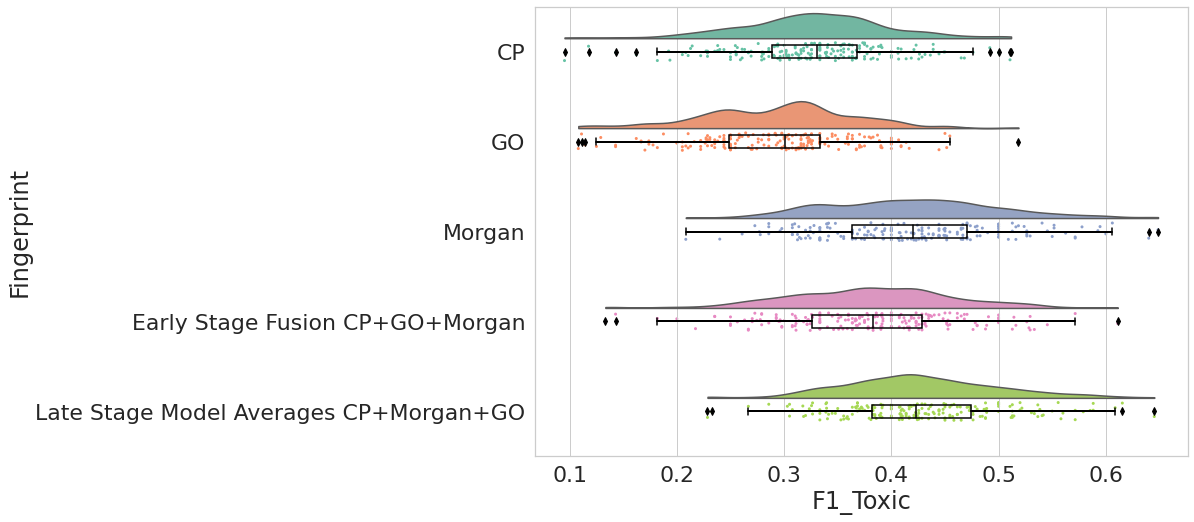

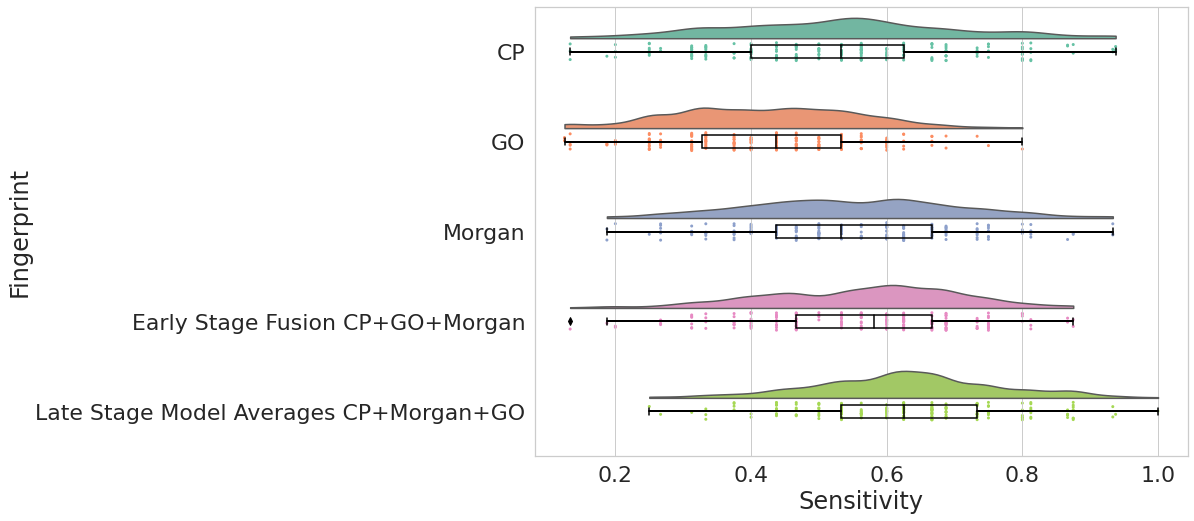

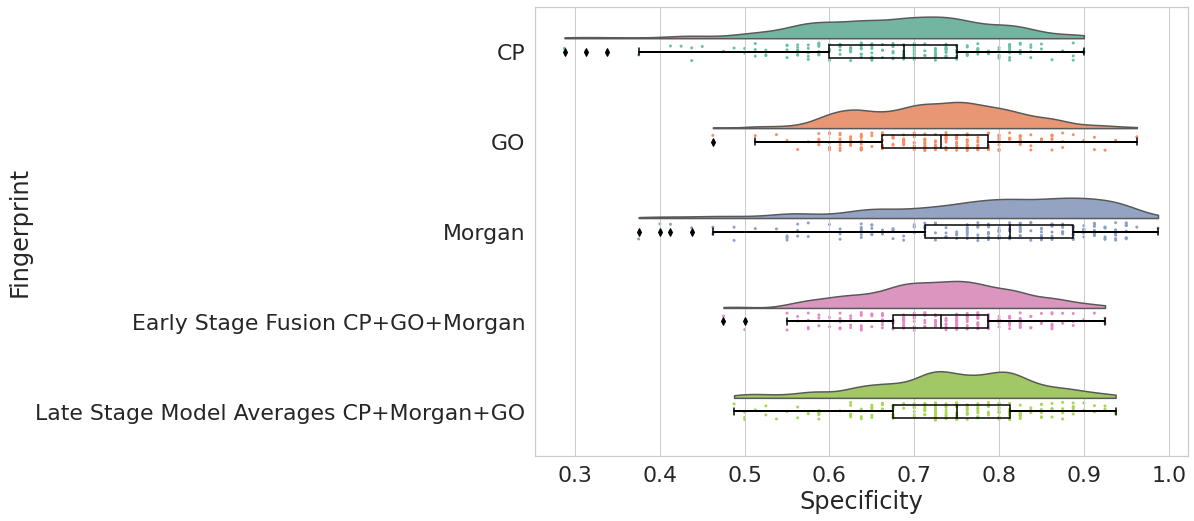

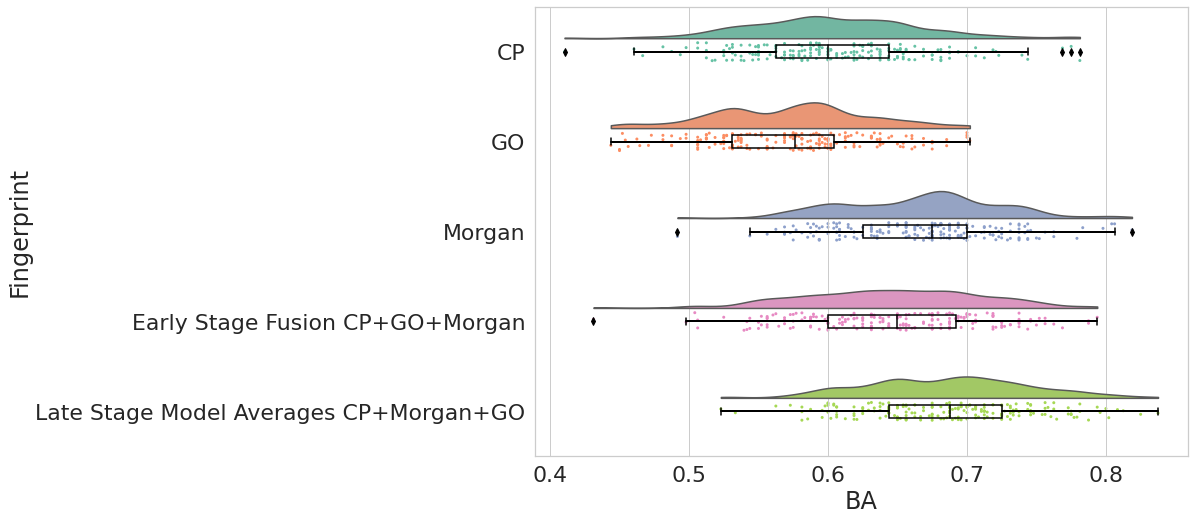

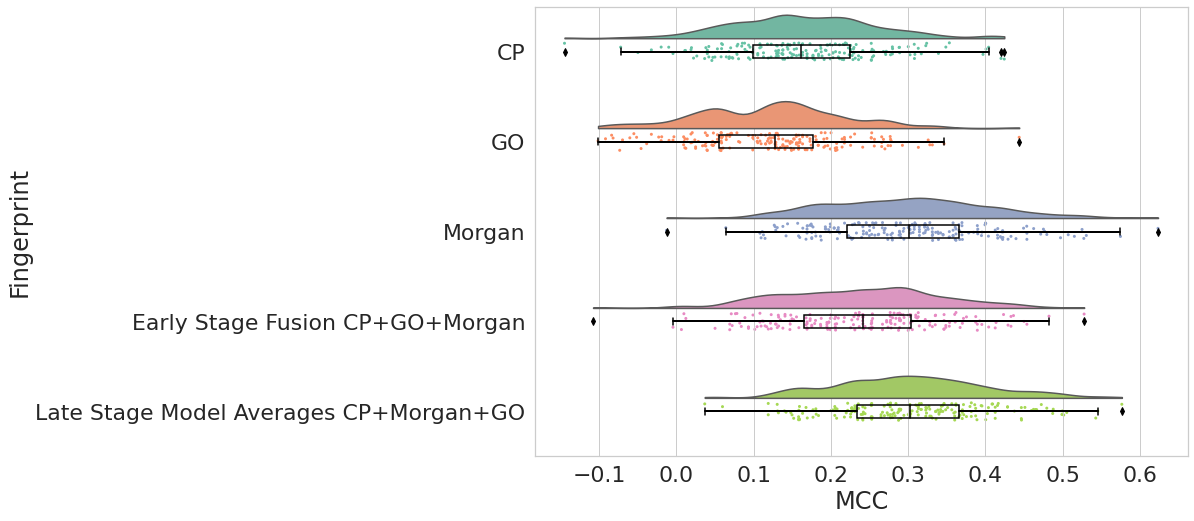

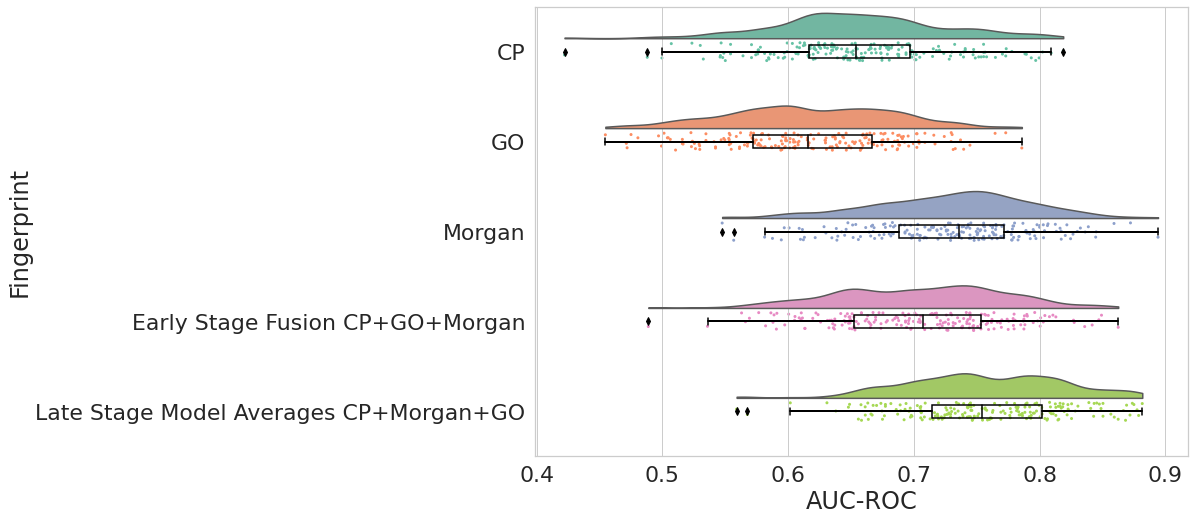

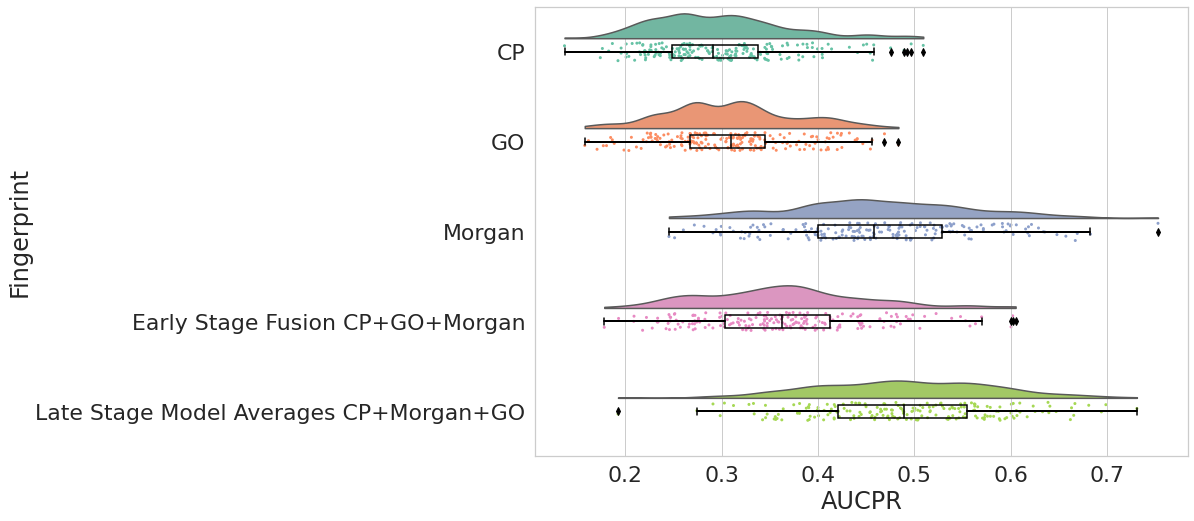

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
for variable in ["F1_Toxic", "Sensitivity", "Specificity", "BA", "MCC", "AUC-ROC", "AUCPR"]: 
    pal = "Set2"

    sns.set(rc={'figure.figsize':(11.7,8.27)}, font_scale=2)

    sns.set_style("whitegrid")
    ax=pt.half_violinplot( x = variable, y = 'Fingerprint', data = df_results[df_results.Type=="Held-Out"], palette = pal,
         bw = .2, cut = 0.,scale = "area", width = .6, 
         inner = None, orient = 'h')

    ax=sns.stripplot( x = variable, y = 'Fingerprint', data = df_results[df_results.Type=="Held-Out"], palette = pal,
          edgecolor = "white",size = 3, jitter = 1, zorder = 0,
          orient = 'h')

    ax=sns.boxplot( x = variable, y = 'Fingerprint', data = df_results[df_results.Type=="Held-Out"], color = "black",
          width = .15, zorder = 10, showcaps = True,
          boxprops = {'facecolor':'none', "zorder":10}, showfliers=True,
          whiskerprops = {'linewidth':2, "zorder":10}, 
          saturation = 1, orient = 'h')
    plt.show()